   # Extending Single Domain Approach: the effect of interactions

## Here it will be implemented 'my approach' to include interactions in the free energy density within the Stoner-Wohlfarth (single-domain) framework. It will be addressed magnetic interactions, such as dipole-dipole, exchange and dzyaloshinskii-moriya to calculate magnetization curves. Basically, for a given particle 'j' of the array in the step 'k' of the hysteresis procedure, the magnetization value ( described by $(\theta_j,\phi_j)$) of its neighbors will be approximated by its value in the step 'k-1'th (previous computation of the magnetic moments orientation). In this way, starting from technical saturation at high fields, the magnetization angles of the whole array can be calculated through common energy minimization procedures. The approach succeeds when the field-step is small enough to assure convergence of the calculations.

In [176]:
# the necessary import statements!

# to paralelize and accelerate the calculations
import numba as nb
from numba import jit
from numba import njit


import joblib
from joblib import Parallel, delayed
import multiprocessing


# numpy for fast calculations using arrays
import numpy as np

# scipy for minimization
import scipy
from scipy import optimize
from scipy.optimize import minimize as spmin
from scipy.optimize import Bounds

# some trigonometric functions
from math import pi, sin, cos, sqrt
import math

# to plot graphics
import matplotlib.pyplot as plt
%matplotlib inline

# the time of some calculations
import timeit

import dlib

import random

from tqdm import tnrange, tqdm_notebook

In [177]:
#from numba import numba_scipy

In [6165]:
# parameters of the simulation

Msat=float(1000)
Ms=float(1/1000)

K1=float(((-0*2.50)*10**4))
K2=float((-0*1.0*10**5))
Kuni=float((-1*1*5.5*10**4))
Kuni2=float((0*0.5*10**4))
K1mel=float((-0*1.5*10**4))
K1out=float((0*2.0*10**4))
Knucl=float((0*1.0*10**4))

Neff=float(-0.00*1.000)
#field-dependent anisotropy
Kfd=float(-0*0.30*10**0)
#Krot=float((1*2.50*10**4))
Krot=float((-0*0.55*10**4))
Krot2=float((-0*1.80*10**3))
htheta=float(+2*pi/4.-0.97+1.00*pi/180.)
hphi=float(2*pi/4+5.00*pi/180.)

# Nanoparticle arrangement order
# 1-> square
# 2-> ring
# 3-> nanomembrane
np_order = 1


Nparticles=2

height=1

NN=Nparticles**3
NN2=Nparticles**2

# interaction strengths!

m = 0*0.005

beta = 0*0.002

jota = -0*0.002

jotabi = 0*0.01



In [6166]:
np.arccos(1/3.),np.arccos(1/1.71)

(1.2309594173407747, 0.9461686134701807)

In [6167]:
htheta

0.6182496193148399

In [6168]:
print(beta,m,K1/Msat**2,Kuni)

0.0 0.0 0.0 -55000.0


In [6169]:
# applied field parameters

hini=204.00*1
hfinal=-204.00*1
step=600*1
stepmag=0.15/step
stepmag=0.00/step
hpasso=(hfinal-hini)/step
print(K1,K2,Krot,Msat,step)

0.0 0.0 0.0 1000.0 600


In [6170]:
# array for angle dispersion in 'phi' and 'theta'

phi_np = np.array([0*random.random() for x in range(NN2)],dtype=np.float64)
theta_np = np.array([0*random.random() for x in range(NN2)],dtype=np.float64)
#print(phi_np)

In [6171]:
# the function that defines the common magnetic anisotropy terms
#@jit(nopython=True)
@jit(nopython=True,parallel=True)
#def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat,i,j,phiantarray,thetaantarray):

    phiant=phiantarray[j]
    thetaant=thetaantarray[j]

#    anis+=Kuni/(Msat**2)*np.sin(phi-3.1415/4.)**2*np.sin(theta-3.1415/4.)**2
#    anis=Kuni/(Msat**2)*np.sin(phi-3.1415/4.)**2*np.sin(theta-0.94)**2

    anis=Kuni/(Msat**2)*np.sin(phi)**2*np.sin(theta)**2
#    anis=Kuni/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4+np.sin(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2+np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2)
#    anis=Kuni/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4)
    
#    theta=theta+0.97
#    phi=phi-3.1415/4.

    
# first-order cubic magnetocrystalline anisotropy
#    anis=K1/(Msat**2)*(np.sin(phi-3.14/4.)**2*np.cos(phi-3.14/4.)**2*np.sin(theta-0.94)**4+np.sin(phi-3.14/4.)**2*np.sin(theta-0.94)**2*np.cos(theta-0.94)**2+np.cos(phi-3.14/4.)**2*np.sin(theta-0.94)**2*np.cos(theta-0.94)**2)
#    anis=K1/(Msat**2)*(np.sin(phi-3.14/4.)**2*np.cos(phi-3.14/4.)**2*np.sin(theta)**4+np.sin(phi-3.14/4.)**2*np.sin(theta)**2*np.cos(theta)**2+np.cos(phi-3.14/4.)**2*np.sin(theta)**2*np.cos(theta)**2)
    anis+=K1/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4+np.sin(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2+np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2)

# second-order cubic magnetocrystalline anisotropy    
    anis+=K2/(Msat**2)*np.sin(phi)**2*np.sin(theta)**2*np.cos(phi)**2*np.sin(theta)**2*np.cos(theta)**2

    
    
    
# demagnetizing energy
    anis+=2*3.1415*Neff*np.cos(theta)**2

    anis+=Knucl/(Msat**2)*np.sin(theta-thetaant)*np.cos(phi-phiant)**1
    
    anis+=K1out/(Msat**2)*np.cos(theta)**2

    
    # magelas anisotropy 
    
#    anis+=K1mel/(Msat**2)*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2
#    anis+=K1mel/(Msat**2)*np.cos(theta)**2
    anis+=K1mel/(Msat**2)*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2
    
    
# uniaxial anisotropy 
    
    
# uniaxial anisotropy 
    
    anis+=Kuni2/(Msat**2)*np.sin(phi-3.1415/4.)**4*np.sin(theta-0.94)**4

# field dependent anis!

#    anis+=Kfd/(Msat**2)*h*Msat*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))
    anis+=Kfd/(Msat**2)*h*Msat**2*(np.sin(theta)*np.cos(phi-3.1415/4.))**2
    
# rotatable anis!

#    anis+=Krot/(Msat**2)*(h*Msat)**1*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**1
#    anis+=Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta-theta_np[i])*np.cos(phi-phi_np[i]-hphi)+np.cos(htheta)*np.cos(theta-theta_np[i]))**2
    
    if(abs(h*Msat)>100):
    
        anis+=0*Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**2
    else:
        anis+=(100-abs(h*Msat))/100.*Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**2
        
    anis+=Krot2/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**4
    
    
    return anis
    

In [6172]:
# Zeeman Energy

#@jit(nopython=True)
@jit(nopython=True,parallel=True)
def zeeman_energy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
    

    zeeman=-h*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))


    return zeeman


In [6173]:
# creating positions!
# this is for creating positions!

#@jit(nopython=True,parallel=True)
#@jit(nopython=True)
def create_pos(np_order,NN2):
    
    if(np_order==1):
        
        nnx=int(sqrt(NN2))
        nny=int(sqrt(NN2))
        
        coord_pos = []
#        coord_pos = np.zeros((nnx,nny,nnx))
#        coord_pos = np.zeros(NN2)
        
        for i in range(nnx):

            for j in range(nnx):
                
#                coord_pos.append([i,j,0])
                coord_pos.append([1*i,1*j,0])
#                coord_pos = np.append(coord_pos,[1*i,1*j,0])

#                coord_pos[i][j][0] = np.array([1*i,1*j,0])
    
    elif(np_order==2):
        
        coord_pos=[]
        
        for i in range(NN2):
            
            coord_pos.append([NN2*math.cos(2*pi*i/NN2),NN2*math.sin(2*pi*i/NN2),0])
    
    elif(np_order==3):
        
        coord_pos=[]
        
        for j in range(height):
        
            for i in range(NN2):

                coord_pos.append([NN2*math.cos(2*pi*i/NN2),j,NN2*math.sin(2*pi*i/NN2)])

    return np.array(coord_pos,dtype=np.float64)


In [6174]:
# this is to create the angles, which are used in the computation of the interactions!

ar_pos=create_pos(np_order,NN2)


#@jit(nopython=True,parallel=True)
@jit(nopython=True)
def angles_vecs(NN2):

    print(np_order)
#    ar_pos=create_pos(np_order,NN2)

#    print(ar_pos)
    
    x_coord = [ar_pos[i][0] for i in range(NN2*height)]
    y_coord = [ar_pos[i][1] for i in range(NN2*height)]
    z_coord = [ar_pos[i][2] for i in range(NN2*height)]

    x_ang = []
    y_ang = []
    
    for i in range(NN2*height):
        x_ang_menor=[]
        y_ang_menor=[]
        
        for j in range(NN2*height):
            
            if(i!=j):
                innerproduct = x_coord[i]*x_coord[j]+y_coord[i]*y_coord[j]

                dist1 = sqrt(x_coord[i]**2+y_coord[i]**2+z_coord[i]**2)
                dist2 = sqrt(x_coord[j]**2+y_coord[j]**2+z_coord[j]**2)
                
                distnewvec = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2+(z_coord[j]-z_coord[i])**2)
                distnewvecplane = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2)
                
                if(distnewvecplane!=0.0):
#                    angphi = math.acos((x_coord[j]-x_coord[i])/distnewvecplane)
#                    angtheta = math.acos((z_coord[j]-z_coord[i])/distnewvec)
                    angphi = math.acos((x_coord[i]-x_coord[j])/distnewvecplane)
                    angtheta = math.acos((z_coord[i]-z_coord[j])/distnewvec)
                elif(distnewvecplane == 0.0):
                    angphi = 0.0
                    angtheta = 3.1415/2.
                x_ang_menor.append(angphi)
                y_ang_menor.append(angtheta)
                
            elif(i==j):
                
                x_ang_menor.append(0.0)
                y_ang_menor.append(0.0)
                
        x_ang.append(x_ang_menor)
        y_ang.append(y_ang_menor)
        x_ang_menor=[]
        y_ang_menor=[]
                

                
#    return np.array(x_ang,dtype=np.float64),np.array(y_ang,np.float64)
#    return np.array(x_ang),np.array(y_ang)
    return x_ang,y_ang

In [6175]:
# Function to calculate the distance between particles 'i' and 'j'

#@jit(nopython=True)
def dist_dipolar(i,j):
    sizex=int(sqrt(NN2))
    sizey=int(sqrt(NN2))
    
    # distance of particle 'j' from particle 'i'
#    distdip=[]
    '''
    for ii in range(sizex):
        for jj in range(sizey):
            distdip.append(sqrt((int(i/sizex)-ii)**2+(int(i%sizey)-jj)**2))
    '''
    
    '''
    distdip=sqrt((int(i/sizex)-int(j/sizex))**2+(int(i%sizey)-int(j%sizey))**2)
    '''

    if(np_order==1):

        distdip=[]
        for ii in range(NN2):
            distdip1=[]
            for jj in range(NN2):
                distdip1.append(sqrt((int(ii/sizex)-int(jj/sizex))**2+(int(ii%sizey)-int(jj%sizey))**2))
            distdip.append(distdip1)
            
    elif(np_order==2):
        
        distdip=[]
#        distdip=np.empty(NN2)
        for ii in range(NN2):
            distmin=[]
            distdip1=[]
            for jj in range(NN2):
                distdip1.append(sqrt((math.cos(2*pi*ii/NN2)-math.cos(2*pi*jj/NN2))**2+(math.sin(2*pi*ii/NN2)-math.sin(2*pi*jj/NN2))**2))
            
                if(ii!=jj):
                    distmin.append(sqrt((math.cos(2*pi*ii/NN2)-math.cos(2*pi*jj/NN2))**2+(math.sin(2*pi*ii/NN2)-math.sin(2*pi*jj/NN2))**2))

            arraydistmin=np.array(distmin)
            
            distdip1new=[]
            
            for u in range(NN2):
                distdip1new.append(distdip1[u]/np.amin(arraydistmin))
            
            distdip.append(distdip1new)
#            distdip1=np.array(distdip1)
#            distmin=np.array(distmin)
#            distdip[ii]=distdip1/np.amin(distmin)
#            distdip=np.array(distdip)


    elif(np_order==3):
        
        distdip=[]
#        distdip=np.empty(NN2)
        for ii in range(NN2*height):
            distmin=[]
            distdip1=[]
            for jj in range(NN2*height):
#                for kkk in range(height):
#                    for kk in range(height):
           
                distdip1.append(sqrt((math.cos(2*pi*(ii%NN2)/NN2)-math.cos(2*pi*(jj%NN2)/NN2))**2+(math.sin(2*pi*(ii%NN2)/NN2)-math.sin(2*pi*(jj%NN2)/NN2))**2+((int(ii/NN2)-int(jj/NN2))/height)**2))

                if(ii!=jj):
                
                    distmin.append(sqrt((math.cos(2*pi*(ii%NN2)/NN2)-math.cos(2*pi*(jj%NN2)/NN2))**2+(math.sin(2*pi*(ii%NN2)/NN2)-math.sin(2*pi*(jj%NN2)/NN2))**2+((int(ii/NN2)-int(jj/NN2))/height)**2))

            arraydistmin=np.array(distmin)

            distdip1new=[]
            if(np.amin(arraydistmin)==0.0):
                print(ii,'ii')
                print(distdip1[1])
                print('zerou',np.argmin(arraydistmin),arraydistmin[np.argmin(arraydistmin)-1])
                break

            for u in range(NN2*height):
                distdip1new.append(distdip1[u]/np.amin(arraydistmin))

            distdip.append(distdip1new)



#        distdip=[]
        
#    return np.array(distdip,dtype=np.float64)
#    return distdip[j]
    return distdip


In [6176]:
ii=20
jj=30
print(len(dist_dipolar(2,3)))
dist_dipolar(20,30)[14][25]

4


IndexError: list index out of range

In [6177]:
sqrt((10%height/height)**2)
(((0%height)-(int(320/height)))/height)**2

102400.0

In [6178]:
math.cos(2*pi*(64%NN2)/NN2)

1.0

In [6179]:
dd=np.zeros((9),dtype=np.object)
print(dd[2])
dd[1]=np.array((1,2))
print(dd)

0
[0 array([1, 2]) 0 0 0 0 0 0 0]


In [6180]:
print(10%int(sqrt(NN2)),10/int(sqrt(NN2)))
print(int(sqrt(NN2)))

0 5.0
2


In [6181]:
vec_dip=np.array(dist_dipolar(20,30))

In [6182]:
len(vec_dip[13])

IndexError: index 13 is out of bounds for axis 0 with size 4

In [6183]:
import itertools

In [6184]:
x_ang,y_ang = angles_vecs(NN2)
#rr=dist_dipolar(i)
x_ang=np.array(x_ang,dtype=np.float64)
y_ang=np.array(y_ang,dtype=np.float64)

1


In [6185]:
len(x_ang[13])

IndexError: index 13 is out of bounds for axis 0 with size 4

In [ ]:
y_ang[13]

In [ ]:
# the interactions
#vec_dip_called = np.array(vec_dip)

#@jit(nopython=True)
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_dipolar=-3*beta/(rr**3)*(np.sin(theta)*np.sin(y_ang[i][j])*np.cos(phi-x_ang[i][j])+np.cos(theta)*np.cos(y_ang[i][j]))*(np.sin(thetaant)*np.sin(y_ang[i][j])*np.cos(phiant-x_ang[i][j])+np.cos(thetaant)*np.cos(y_ang[i][j]));
    inter_dipolar+=beta/(rr**3)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))

#    print(inter_dipolar,'dipolar')
    
    return inter_dipolar
    
# exchange energy

# moriya energy



In [6186]:
energy_interdipolar(0.2,0.5,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

0.0

In [6187]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_exc=jota*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_exc


In [6188]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_biinterexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_excbi=jotabi*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))**2
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_excbi


In [6189]:
# the interactions
#vec_dip_called = np.array(vec_dip)

#@jit(nopython=True)
@jit(nopython=True,parallel=True,fastmath=True)
def energy_moriya(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)

#   vectorial product with k^ versor !

    if(i<=j):
        if(j==i+1):
            ## produto vetorial z^ vec x^ = y^!
#            inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));

#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
#            inter_moriya+=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
        
            # biquadratic
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
            # chiral multi spin
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            
        else:
            ## produto vetorial z^ vec y^ = - x^!
#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));

#            inter_moriya=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
#            inter_moriya+=+m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
        
            # biquadratic
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
            inter_moriya+=+m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
        
            # chiral multi spin
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
        
    elif(i>=j):
        if(j==i-1):
#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));

#            inter_moriya=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
        
            # biquadratic
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
            # chiral multi spin
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            
        else:
#            inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));

#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
#            inter_moriya+=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
            
            # biquadratic
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
            
            # chiral multi spin
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));

#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));


#    inter_moriya=m*np.exp(-rr**3)/np.exp(-1.0)*(np.cos(phi)*np.sin(phiant)*np.sin(theta)*np.sin(thetaant)-np.cos(phiant)*np.sin(phi)*np.sin(theta)*np.sin(thetaant));
#    inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.sin(phi-phiant));

    

    
#    inter_moriya+=beta/(rr**3)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))

#    print(m,'dipolar')
    
    return inter_moriya
    
# exchange energy

# moriya energy



In [6190]:
energy_moriya(1.0,1.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,10,3)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-6189-102298d21f12>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_moriya(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  self.func_ir.loc))


0.0

In [6191]:
np.exp(-1.0),vec_dip[4]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [6192]:
energy_interexchange(0.0,0.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-6187-ced6ec3e3998>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  self.func_ir.loc))


0.0

In [6193]:
energy_biinterexchange(0.0,0.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-6188-c27d49cfb87b>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_biinterexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  self.func_ir.loc))


0.0

In [6194]:
# energy array

#@jit(nopython=True,parallel=True)
#@jit(nopython=True)
@njit(fastmath=True,parallel=True)
def energy_array_inter(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    '''
    
    listaNN1=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN1[x] = int(sqrt(NN2))-x-2
                                
    listaNN2=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN2[x] = int(sqrt(NN2))*(x+2)-1
                                
    listaNN3=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN3[x] = NN2-x-2
    
    listaNN4=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN4[x] = int(sqrt(NN2))*(x+1)

#    print('listas',listaNN1,listaNN2,listaNN3,listaNN4)

    """
    for x in range(NN2):
        
        x=i
        for y in range(int(sqrt(NN2))-2):
            
            print(listaNN3[y]==x)
#            print(x,y,'xy')
                                
            if(listaNN1[y]==x):
                                
                foi=-1
                                
            elif(listaNN2[y]==x):
                                
                foi=-2
#                print(foi,'foi dentro',listaNN3[y],x)
                                
            elif(listaNN3[y]==x):
                                
                foi=-3
#                print(foi,'foi dentro',listaNN3[y],x)
                                
            elif(listaNN4[y]==x):
                                
                foi=-4
            else:
                                
                foi=-5
#            print(foi,'foi dentro',listaNN3[y],x)
    """                         

    
        
    x=i
    for y in range(int(sqrt(NN2))-2):
            
#        print(listaNN3[y]==x)
#            print(x,y,'xy')
                                
        if(listaNN1[y]==x):
                                
            foi=-1
            break
                                
        elif(listaNN2[y]==x):
                                
            foi=-2
#                print(foi,'foi dentro',listaNN3[y],x)
            break
                                
        elif(listaNN3[y]==x):
                                
            foi=-3
            break
#                print(foi,'foi dentro',listaNN3[y],x)
                                
        elif(listaNN4[y]==x):
                                
            foi=-4
            break
        else:
                                
            foi=-5
#            print(foi,'foi dentro',listaNN3[y],x)
    
    
    
#    print(foi,'foi fora')
                                
#    print(i,j)
    
    # defining the energy array!
    energy_vec=[0.0 for x in range(NN2)]
    
    
    if(np_order==1):
        
        if(i==0):
        
            dip_b=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2)))
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2))-1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,NN2-int(sqrt(NN2)))
            
            
            energy_vec[i]=dip_b

    
        elif(foi==-1):
                
                
#            print(i,'i dentro de foi=-1')
            
            dip_f=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,NN2-int(sqrt(NN2))+i)
            
#            print(dip_f,'dip_f')
    
            energy_vec[i]=dip_f

        elif(i==int(sqrt(NN2)-1)):
                                
            dip_c=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,int(sqrt(NN2))-2)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,2*int(sqrt(NN2))-1)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,0)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,NN2-1)

            energy_vec[i]=dip_c

        elif(foi==-2):

            
            dip_q=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2))+1)
            
            energy_vec[i]=dip_q

        elif(i==NN2-1):
                                
            dip_e=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))-2)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))+1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_e

        elif(i==NN2-int(sqrt(NN2))):
                                
            dip_d=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-int(sqrt(NN2))+1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-2*int(sqrt(NN2)))
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),0)
                                
            energy_vec[i]=dip_d
                                
        elif(foi==-3):
                                
            dip_g=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-i%(int(sqrt(NN2))))
            
            energy_vec[i]=dip_g
                                
        elif(foi==-4):
            
            
#            print('aqui o erro!')
            
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_p
                                
        else:
            
#            print('aqui o erro!')
            
                                
            dip_a=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
                                
            energy_vec[i]=dip_a
    '''                         
    # defining the energy array!
#    energy_vec=[0.0 for x in range(NN2)]

    # summing up all the contributions    
#    '''
    if(np_order==1 or np_order==2):
        soma_dip = 0.0
        for j in nb.prange(NN2):
            if(i!=j):
                soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_biinterexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_moriya(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
    elif(np_order==3):
        soma_dip = 0.0
        for j in nb.prange(NN2*height):
#        for j in range(NN2*height):
            if(i!=j):
                soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
#                print(j,soma_dip)
#    '''
#    soma_dip = sum(energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j) for j in range(NN2))
    '''

    soma_dip = []
    soma_dip=np.array([energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j) for j in range(NN2) if i!=j])
    soma_dip=np.sum(soma_dip)
    '''
    
#    energy_vec[i]=soma_dip
                                
                                
#    return energy_vec
#    return np.array(energy_vec)
    return soma_dip
                                
                                
                                
                                
                                
                                
                                
                                

In [6195]:
xx,yy=angles_vecs(NN2)

1


In [6196]:
#xx
type(list(range(NN2)))
#list(range(NN2))

list

In [6197]:
for k in range(int(sqrt(NN2))-2):
    print(k)

In [6198]:
phiantarray

array([0.34103543, 0.37502098, 0.70894345, 0.43840255])

In [6199]:
thetaantarray

array([0.33734444, 0.69469922, 0.73032757, 0.48574139])

In [6200]:
energy_array_inter(1,0,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,4,5)
#print(beta)

<ipython-input-6194-99a4e3765717>:214: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-6125-48bf7c2af5c4>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
<ipython-input-6194-99a4e3765717>:215: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-6187-ced6ec3e3998>", line 2:
@jit(nopython=True,parallel=True,fa

SystemError: CPUDispatcher(<function energy_array_inter at 0x7febda642400>) returned a result with an error set

In [ ]:
h

In [ ]:

ar_pos=create_pos(np_order,NN2)

ar_pos[0][0]

x_coord = [ar_pos[i][0] for i in range(NN2)]
y_coord = [ar_pos[i][1] for i in range(NN2)]
z_coord = [ar_pos[i][2] for i in range(NN2)]

print(x_coord)
print(y_coord)
print(z_coord)


In [ ]:
a,b=angles_vecs(NN2)
int(sqrt(NN2))

In [ ]:
energy_vec=[0 for x in range(NN2)]

energy_vec[1]=2

energy_vec

In [ ]:
import random

phiantarray=np.array([random.random() for x in range(NN2*height)],dtype=np.float64)
thetaantarray=np.array([random.random() for x in range(NN2*height)])
h=0.16
ii=3
print(energy_array_inter(-0.8,-1.2,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,ii,2))

#phiantarray
#thetaantarray

In [ ]:
phiantarray

In [ ]:
#@jit(nopython=True,parallel=True)
@jit(nopython=True,fastmath=True)
def free_energy(xx,K1,K2,h,htheta,hphi,Msat,i,phiantarray,thetaantarray):

#    anis = anisotropy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)
    anis = anisotropy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i,j,phiantarray,thetaantarray)

    zeeman = zeeman_energy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)

    inter = energy_array_inter(xx[0],xx[1],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,0)
#    inter = energy_array_inter(xx[0],xx[1],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,3,0)
    
    expr_calc = anis + zeeman + inter
    
#    return np.array(expr_calc,dtype=np.float64)
    return expr_calc
    
    

In [ ]:
#testing!
h=-5.01
ii=3
x0=np.array([0,1.57],dtype=np.float64)
a=free_energy(np.array([0,1.57],dtype=np.float64),K1,K2,h,htheta,hphi,Msat,ii,phiantarray,thetaantarray)
print(a)
minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,ii,phiantarray,thetaantarray),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
print(minxy)

In [ ]:
hini,NN2,step
from numba import vectorize,stencil

In [6201]:
# the main program, where minimization of overall energy is performed!



#@jit(nopython=True)
#@jit(fastmath=True)
#@vectorize
#@stencil
def hysteresis_inter(NN2,Msat,hpasso):
    
    
    hnow=hini/Msat
    
#    hnowlist=np.array([])
#    maglist=np.array([])
#    maglistend=np.array([])


    hnowlist=np.empty(step+1)
    maglist=np.zeros(NN2*height+1)
    maglistend=np.array([])


    Msat0=Msat
#    for particle in range(NN2):
#    for i in range(1,int(step+1)):

    Msat=Msat0
#    maglistend0=np.array([[]])
    maglistend0 = np.empty(step, dtype=object)
#    maglistend0 = np.zeros(step, dtype=np.float64)
    
    hnow=hini/Msat
    htest=np.array([])
    hlist=np.array([])


#    for i in range(1,step+1):


#    for i in range(1,step+1):
    for i in tnrange(step+1,desc='Calculation Progress'):

        if(i==0):
            continue
        
        if(hnow>=0):
            coefmag=(1+(step/2-i)*2*stepmag)
#            coefmag=(1-(step/2-i)*stepmag)
        else:
            coefmag=(1+(i-step/2)*2*stepmag)
#            coefmag=(1-(i-step/2)*stepmag)
        
#        phiantarraynew=np.array([])
#        thetaantarraynew=np.array([])
        phiantarraynew=np.empty(NN2*height)
        thetaantarraynew=np.empty(NN2*height)
        
#        for i in range(1,int(step+1)):
        for particle in range(NN2*height):
            
#            print(particle,'particle')
            
                
#            print(coefmag,'coefmag')
#            print(i,'i loop')
            if(i==1):
            
                angx=hphi#+np.pi
                angy=htheta#+np.pi
                
                phiantarray_vai=np.array([hphi for x in range(NN2*height)],dtype=np.float64)
                thetaantarray_vai=np.array([htheta for x in range(NN2*height)],dtype=np.float64)
#                phiantarray=np.array(phiantarray)
#                thetaantarray=np.array(thetaantarray)
                
#                print(phiantarray_vai)

                h=hnow
                    
                Msat=Msat0*coefmag
                
                angx=phiantarray_vai[particle]
                angy=thetaantarray_vai[particle]
                
                x0=np.array([angx,angy],dtype=np.float64)
                
#                print(x0,'x0')
#                minxy=spmin(free_energy,[x0],args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-400,options={'ftol': 1e-300})
                
#                print('chegaaqui')
            
                angx=minxy.x[0]
                angy=minxy.x[1]
                #print(angx,'angx')
#                phiantarraynew.append(angx)
#                thetaantarraynew.append(angy)
#                phiantarraynew=np.append(phiantarraynew,angx)
#                thetaantarraynew=np.append(thetaantarraynew,angy)
                phiantarraynew[particle] = angx
                thetaantarraynew[particle] = angy

        
        
        
        
#                print(phiantarraynew,np.array([angx]))
#                dfsol=minxy.x[2]
#                print(phiantarraynew)
#                hlist.append(hnow*Msat)
#                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
#                maglist=np.append(maglist,coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
                maglist[particle] = coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy)))

                if(particle==NN2*height-1):
                    phiantarraynew2=np.copy(phiantarraynew)
                    thetaantarraynew2=np.copy(thetaantarraynew)
                    print(phiantarraynew)
                    
#                phiantarraynew=[]
#                thetaantarraynew=[]
#            hnow=hnow+hpasso/Msat

#            hnowlist.append(hnow*Msat)
#            hnowlist=np.append(hnowlist,hnow*Msat)

            
#            print(i,'ii')    
#            print(phiantarraynew2,'phiant2')
#            print(maglist,'maglist')

#            phiantarraynew=[]
#            thetaantarraynew=[]
            
            
            if(i!=1):
                
                if(particle==0):
                    phiantarray_vai=np.copy(phiantarraynew2)
                    thetaantarray_vai=np.copy(thetaantarraynew2)
#                print(phiantarray_vai)

#                phiantarray=np.array(phiantarray)
#                thetaantarray=np.array(thetaantarray)
#                print(phiantarray,'secondphiantarray')

                angx=phiantarray_vai[particle]
                angy=thetaantarray_vai[particle]
                
                Msat=Msat0*coefmag
                #            x0=np.array([angx,angy,dfsol],dtype="float")
                x0=np.array([angx,angy],dtype=np.float64)
                h=hnow
                
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),method='nelder-mead',tol=1e-400,options={'ftol': 1e-300})
                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-400,options={'ftol': 1e-300})
                
                angx=minxy.x[0]
                angy=minxy.x[1]
#                phiantarraynew.append(angx)
#                thetaantarraynew.append(angy)
#                phiantarraynew=np.append(phiantarraynew,angx)
#                thetaantarraynew=np.append(thetaantarraynew,angy)
                phiantarraynew[particle] = angx
                thetaantarraynew[particle] = angy
        
#                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))

#                maglist=np.append(maglist,coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
                maglist[particle] = coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy)))
            
#                hlist.append(hnow*Msat)
#                phiantarraynew3=np.copy(phiantarraynew)
#                thetaantarraynew3=np.copy(thetaantarraynew)
#                phiantarraynew=[]
#                thetaantarraynew=[]

#                htest.append(minxy)
#                htest=np.append(htest,minxy)

                
                if(particle==NN2*height-1):
                    phiantarraynew2=np.copy(phiantarraynew)
                    thetaantarraynew2=np.copy(thetaantarraynew)
                    phiantarraynew=[]
                    thetaantarraynew=[]
#                    print(thetaantarraynew2)
#            hnow=hnow+hpasso/Msat

#            hnowlist.append(hnow*Msat)
#        hnowlist=np.append(hnowlist,hnow*Msat)
        hnowlist[i] = hnow*Msat
            
            #phiantarraynew=[]
            #thetaantarraynew=[]

#        hlist.append(hnow*Msat)
        hlist=np.append(hlist,hnow*Msat)
#        if(i==int(step/2)):
#            hpasso=-hpasso
            
            
#        hnow=hnow+2*hpasso/Msat            
        hnow=hnow+1*hpasso/Msat            

#        maglistend0.append(np.array(maglist)) 
#        maglist=[]
#        print(maglist,'maglist')
        if(i==1):
#            maglistend0=np.array([maglist])
            maglistend0[i-1] = maglist
        else:
#            maglistend0=np.concatenate((maglistend0,np.array([maglist])),axis=0)
            maglistend0[i-1] = maglist
#            print(len(maglist),'lenmag')
#        maglist=np.array([])
        maglist=np.zeros(NN2*height+1)
            
#    print(maglistend0)
#    print(len(maglistend0))
#    maglistend2=np.array([])
    maglistend2=np.empty(step)

    for j in range(len(maglistend0)):
        soma=0
        for i in range(len(maglistend0[0])):
            soma+=maglistend0[j][i]

#        maglistend2.append(soma/NN2)
#        maglistend2=np.append(maglistend2,soma/NN2)
#        print(soma/NN2,'soma')
        maglistend2[j]=soma/NN2/height
#        print(maglistend2[i],'aq')
#    maglistend.append(np.array(maglistend2)) 
#    maglistend=np.append(maglistend,maglistend2)
    maglistend=maglistend2

#    print(len(maglistend),'lastmagend')
#    hlist=[((hini+hpasso*x)) for x in range(step)]
#    print(len(htest),'htest')
    
    return maglistend,hlist,htest,hnowlist




In [6202]:
import time
start=time.time()
m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso)
stop=time.time()
print(-start+stop)

[1.71024542 1.71024542 1.71024542 1.71024542]

2.4576077461242676


In [6203]:
vv=[]
vv1=np.array([2,3])
vv1=np.array([vv1])
#print(vv1)
zzz=np.array([[1,2],[4,5]])
#vv1=np.append(zzz,np.array([vv1]))
vv1=np.concatenate((zzz,vv1),axis=0)
vv1=np.concatenate((np.array([[3,23]]),vv1),axis=0)
print(vv1[0],len(vv1[0]))

[ 3 23] 2


In [6204]:
desired_length = 50
resultsnew = np.empty(desired_length)
#print(resultsnew,len(maglist))

In [6205]:
zzz

array([[1, 2],
       [4, 5]])

In [6206]:
lis=[1,2,3]
zz=np.copy(lis)
zz
lis[0]=20
print(lis,zz)

[20, 2, 3] [1 2 3]


In [6207]:
Msat
print(beta,hpasso)

0.0 -0.68


In [6208]:
print(start-stop)

-2.4576077461242676


In [6209]:
hnowlist[-1],hnowlist[0]

(-203.32000000000323, 4.676868064033e-310)

In [6210]:
h_inter[0],h_inter[-1]

(204.0, -203.32000000000323)

In [6211]:
print(m_inter)
print(len(m_inter))

[ 0.97999537  0.97989676  0.97979746  0.97969745  0.97959672  0.97949527
  0.97939309  0.97929018  0.97918654  0.97908214  0.97897698  0.97887107
  0.97876439  0.97865693  0.97854869  0.97843965  0.97832983  0.97821919
  0.97810774  0.97799547  0.97788238  0.97776844  0.97765367  0.97753804
  0.97742155  0.97730419  0.97718596  0.97706684  0.97694683  0.97682592
  0.97670409  0.97658135  0.97645768  0.97633307  0.97620752  0.97608101
  0.97595353  0.97582508  0.97569565  0.97556523  0.9754338   0.97530136
  0.97516789  0.9750334   0.97489786  0.97476126  0.97462361  0.97448488
  0.97434506  0.97420415  0.97406213  0.973919    0.97377474  0.97362933
  0.97348278  0.97333506  0.97318616  0.97303608  0.9728848   0.97273231
  0.9725786   0.97242365  0.97226745  0.97210999  0.97195126  0.97179123
  0.97162991  0.97146728  0.97130332  0.97113801  0.97097136  0.97080332
  0.97063391  0.9704631   0.97029088  0.97011723  0.96994214  0.96976559
  0.96958757  0.96940806  0.96922704  0.96904451  0

In [6212]:
maglistend2=[]
for j in range(len(m_inter)):
    soma=0
    for i in range(len(m_inter[0])):
#        print(i)
        soma+=m_inter[j][i]
    maglistend2.append(soma/NN2)
        

TypeError: object of type 'numpy.float64' has no len()

In [6213]:
print(maglistend2)
print(len(maglistend2))

[]
0


In [6214]:
#h_test[8]


In [6215]:
Msat

1000.0

In [6216]:
hini

204.0

In [6217]:
m_inter

array([ 0.97999537,  0.97989676,  0.97979746,  0.97969745,  0.97959672,
        0.97949527,  0.97939309,  0.97929018,  0.97918654,  0.97908214,
        0.97897698,  0.97887107,  0.97876439,  0.97865693,  0.97854869,
        0.97843965,  0.97832983,  0.97821919,  0.97810774,  0.97799547,
        0.97788238,  0.97776844,  0.97765367,  0.97753804,  0.97742155,
        0.97730419,  0.97718596,  0.97706684,  0.97694683,  0.97682592,
        0.97670409,  0.97658135,  0.97645768,  0.97633307,  0.97620752,
        0.97608101,  0.97595353,  0.97582508,  0.97569565,  0.97556523,
        0.9754338 ,  0.97530136,  0.97516789,  0.9750334 ,  0.97489786,
        0.97476126,  0.97462361,  0.97448488,  0.97434506,  0.97420415,
        0.97406213,  0.973919  ,  0.97377474,  0.97362933,  0.97348278,
        0.97333506,  0.97318616,  0.97303608,  0.9728848 ,  0.97273231,
        0.9725786 ,  0.97242365,  0.97226745,  0.97210999,  0.97195126,
        0.97179123,  0.97162991,  0.97146728,  0.97130332,  0.97

In [6218]:
m_rot=np.array([-1 if(h_inter[i]<-20) else 1 for i in range(len(h_inter))])

In [6219]:
m_rot

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [6220]:
h

-5.01

(-1, 1)

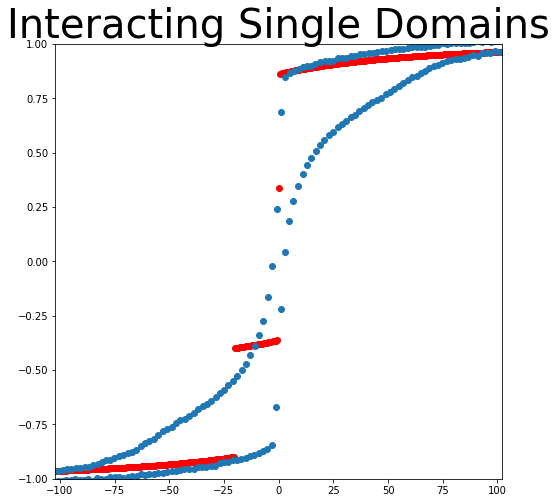

In [6221]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(8,8))

plt.title("Interacting Single Domains",size=40)

#plt.scatter(np.array(h_inter)[:int(len(h_inter)*2/2.)],np.array(m_inter)[:int(len(h_inter)*2/2.)]/norm,color='r')
plt.scatter(np.array(h_inter),(3/4*np.array(m_inter)+1/4*m_rot)/1./norm,color='r')
#plt.scatter(-np.array(h_inter),-np.array(m_inter)/norm,color='b')

plt.scatter(hexp_on,np.array(mexp_on)/0.99)

#plt.xlim(-1600*3*3,1600*3*3)
plt.xlim(-abs(hini/2.),abs(hini/2.))
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')





In [6036]:
hphi/pi

0.5277777777777778

In [4584]:
# experimental data
path='/home/vagner/Desktop/galfenol/gal90deg.txt'
#path='/home/vagner/Desktop/galfenol/gal50deg.txt'
#path = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hexp_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on.append(float(listexp[0]))
    mexp_on.append(float(listexp[1].split('\n')[0]))

9999.71436	1



In [4370]:
mexp_on=np.array(mexp_on)
hant=0
for i in range(len(hexp_on)):
    if(hexp_on[i]>-100 and hant<-100):
        h11_index=i
    if(hexp_on[i]>-200 and hant<-200):
        h22_index=i
    hant=hexp_on[i]


In [2872]:
h11_index
h22_index

1684

In [2873]:
hexp_on[h22_index]-hexp_on[h11_index]

-100.1131

In [2874]:
mexp_on[h22_index]

-0.89326

In [2875]:
mexp_on[h22_index]-mexp_on[h11_index]

-0.09305000000000008

In [2876]:
(mexp_on[h22_index]-mexp_on[h11_index])/(hexp_on[h22_index]-hexp_on[h11_index])*np.array(hexp_on)

array([9.29422245, 9.27334661, 9.26227491, ..., 9.26513541, 9.28456489,
       9.29425285])

In [2877]:
mexp_on=mexp_on-(mexp_on[h22_index]-mexp_on[h11_index])/(hexp_on[h22_index]-hexp_on[h11_index])*np.array(hexp_on)

In [2878]:
norm=abs(mexp_on[h11_index])

In [2879]:
mexp_on=mexp_on/norm

In [4680]:
# experimental data
path1='/home/vagner/Desktop/galfenol/gal90deg.txt'
path2='/home/vagner/Desktop/galfenol/gal50deg.txt'
path3 = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path1,'r')
hexp=hexp10ktube.readlines()


hexp_on1=[]
mexp_on1=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on1.append(float(listexp[0]))
    mexp_on1.append(float(listexp[1].split('\n')[0]))

hexp10ktube = open(path2,'r')
hexp=hexp10ktube.readlines()


hexp_on2=[]
mexp_on2=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on2.append(float(listexp[0]))
    mexp_on2.append(float(listexp[1].split('\n')[0]))
        
    
hexp10ktube = open(path3,'r')
hexp=hexp10ktube.readlines()


hexp_on3=[]
mexp_on3=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on3.append(float(listexp[0]))
    mexp_on3.append(float(listexp[1].split('\n')[0]))
        

In [4689]:
mexp_on1=np.array(mexp_on1)
hant=0
for i in range(len(hexp_on1)):
    if(hexp_on1[i]>-100 and hant<-100):
        h11_index=i
    if(hexp_on1[i]>-200 and hant<-200):
        h22_index=i
    hant=hexp_on1[i]

mexp_on1=mexp_on1-(mexp_on1[h22_index]-mexp_on1[h11_index])/(hexp_on1[h22_index]-hexp_on1[h11_index])*np.array(hexp_on1)    
norm=abs(mexp_on1[h11_index])
mexp_on1=mexp_on1/norm


In [4682]:
mexp_on2=np.array(mexp_on2)
hant=0
for i in range(len(hexp_on2)):
    if(hexp_on2[i]>-100 and hant<-100):
        h11_index=i
    if(hexp_on2[i]>-200 and hant<-200):
        h22_index=i
    hant=hexp_on2[i]

mexp_on2=mexp_on2-(mexp_on2[h22_index]-mexp_on2[h11_index])/(hexp_on2[h22_index]-hexp_on2[h11_index])*np.array(hexp_on2)    
norm=abs(mexp_on2[h11_index])
mexp_on2=mexp_on2/norm


In [4683]:
mexp_on3=np.array(mexp_on3)
hant=0
for i in range(len(hexp_on3)):
    if(hexp_on3[i]>-100 and hant<-100):
        h11_index=i
    if(hexp_on3[i]>-200 and hant<-200):
        h22_index=i
    hant=hexp_on3[i]

mexp_on3=mexp_on3-(mexp_on3[h22_index]-mexp_on3[h11_index])/(hexp_on3[h22_index]-hexp_on3[h11_index])*np.array(hexp_on3)    
norm=abs(mexp_on3[h11_index])
mexp_on3=mexp_on3/norm


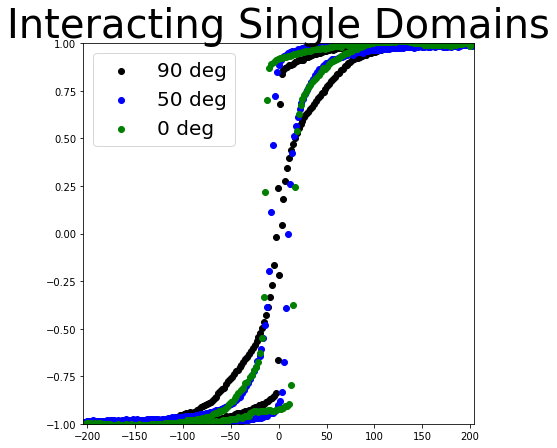

In [4690]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(7,7))

plt.title("Interacting Single Domains",size=40)

l1=plt.scatter(hexp_on1,np.array(mexp_on1),color='black',label='90 deg')
l2=plt.scatter(hexp_on2,np.array(mexp_on2),color='blue',label='50 deg')
l3=plt.scatter(hexp_on3,np.array(mexp_on3),color='green',label='0 deg')

plt.legend((l1,l2,l3),('90 deg','50 deg','0 deg'),fontsize=20)

#plt.xlim(-1600*3*3,1600*3*3)
plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

plt.show()




In [ ]:
path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_perptubeaxis_h.dat'
#path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_alongtubeaxis_h.dat'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hexp10ktube.close()

#hexp = [float(i) for i in hexp]


path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_perptubeaxis_m.dat'
#path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_alongtubeaxis_m.dat'
mexp10ktube = open(path,'r')
mexp=mexp10ktube.readlines()

print(mexp[0])
#print(a1[0][1])

mexp10ktube.close()

#mexp = [float(i)*1.00 for i in mexp]
hexp_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(1,len(hexp)):
#    listexp=hexp[i].split('\t')
#    hexp_on.append(float(listexp[0]))
#    mexp_on.append(float(listexp[1].split('\n')[0]))
#    print(hexp[i],'e',i)
    hexp_on.append(float(hexp[i]))
    mexp_on.append(float(mexp[i]))    

In [ ]:
mexp_on

In [ ]:
stepmag

In [ ]:
coefmag